**Datasets**

*   https://github.com/iamvukasin/flagnet
*   https://iconscout.com/icon-pack/country-flags
*   https://dynamospanish.com/flags/
*   https://flagpedia.net/download








PARA HACER

*   Web app (18:00 lesson 3 2020)



















In [1]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("EOEUTT6CEWI2OVWPFEOZ55VG-7QFAIY27X7AV5QFN")

     |████████████████████████████████| 64 kB 3.1 MB/s 
     |████████████████████████████████| 51 kB 253 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=4d6e06ffd93693d0eb447787ce7f96dbdd696766284cb152e25067d7d0847d83
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


# Configuraciones

In [1]:
# Instalo FastAI
!pip3 install git+https://github.com/fastai/fastai.git

# Importo las librerias
import os
import re
import pandas as pd
from pathlib import Path
from fastai.vision.all import *

# from skimage import io, transform
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms, utils, models

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-b8d56h9z
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-b8d56h9z
     |████████████████████████████████| 56 kB 3.9 MB/s 
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=187524 sha256=3771988cb2610b5916b7cef1f5d675cf72e11283b72c23061b93fead1cbf92d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-l85_vweq/wheels/e2/81/30/9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
# Defino la carpeta de trabajo
folder = Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Proyecto final/')
os.chdir(folder)

# Preparar los datos

Para obtener las etiquetas deseadas, primero es necesario cargar la tabla `countries_label_map` que mapea los códigos alpha-2 con los nombres de los países. Además se necesita de la función `label_func` para extraer los dos caracteres a partir de un `path` e indexar la tabla con ellos. 

In [ ]:
# Cargo la tabla de mapeo
countries_label_map = pd.read_csv(folder/'countries_label_map.csv', index_col=0, encoding='latin-1')
countries_label_map.head()

,country
label,
ad,Andorra
ae,United Arab Emirates
af,Afghanistan
ag,Antigua and Barbuda
al,Albania


In [ ]:
# Función para obtener las etiquetas
def label_func(path): 
  # Uso una expresión regular para extraer los dos caracteres correspondientes a la etiqueta original
  code = re.split(r'\/',str(path))[-2]
  # Y la convierto a nombre de país
  label = countries_label_map.loc[code][0]
  return label

Para evitar que el modelo "memorice" el dataset y se produzca overfitting, es necesario aplicar data augmentation. Esto hace que en cada época de entrenamiento el modelo se encuentre con versiones distorsionadas de las imágenes originales.

In [ ]:
# Elijo los tipos de data augmentation a aplicar
data_augmentation = aug_transforms(do_flip=False,       # No Invierte horizontalmente
                                   flip_vert=False,     # No invierte verticalmente 
                                   max_rotate=50.0,     # Rota al azar
                                   max_zoom=1.2,        # Crop con zoom al azar
                                   max_lighting=0.5,    # Cambia brillo y contraste al azar
                                   max_warp=0.3,        # Cambia perspectiva al azar
                                   p_affine=0.7,        # Probabilidad de rotación, crop y warpeo
                                   p_lighting=0.7)     # Probabilidad de cambios de iluminación

Utilizando la API llamada DataBlock, es sencillo preparar el dataset de forma que quede listo para pasarselo a un modelo. La variable `dls` contiene tanto al dataloader de entrenamiento como el de validación.

 

In [ ]:
# Hiperparámetros
SPLIT = 0.25                                            # Porción de los datos destinados a validación
IMG_SIZE = 224                                          # Tamaño final de las imágenes
BATCH_SIZE = 64                                         # Tamaño del batch

# Elijo como ensamblar los datos
flags = DataBlock(
    blocks=(ImageBlock, CategoryBlock),                 # Creo tuplas (imagen, clase)
    get_items=get_image_files,                          # Obtengo los datos
    get_y=label_func,                                   # Etiqueto con mi propia función
    splitter=RandomSplitter(valid_pct=SPLIT, seed=18),  # Divido al azar en train y valid
    item_tfms=Resize(IMG_SIZE, method='squish'),        # Recorto y redimensiono las imágenes
    batch_tfms=data_augmentation)                       # Hago data augmentation


# Creo los dataloaders
path_train = folder/'train'
dls = flags.dataloaders(path_train, bs=BATCH_SIZE, shuffle=True)

# Exploro los datos
num_classes = dls.c
classes = dls.vocab
print('Cantidad de clases: ', num_classes)
print('Nombres de las clases: ', classes)

Cantidad de clases:  193
Nombres de las clases:  ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 

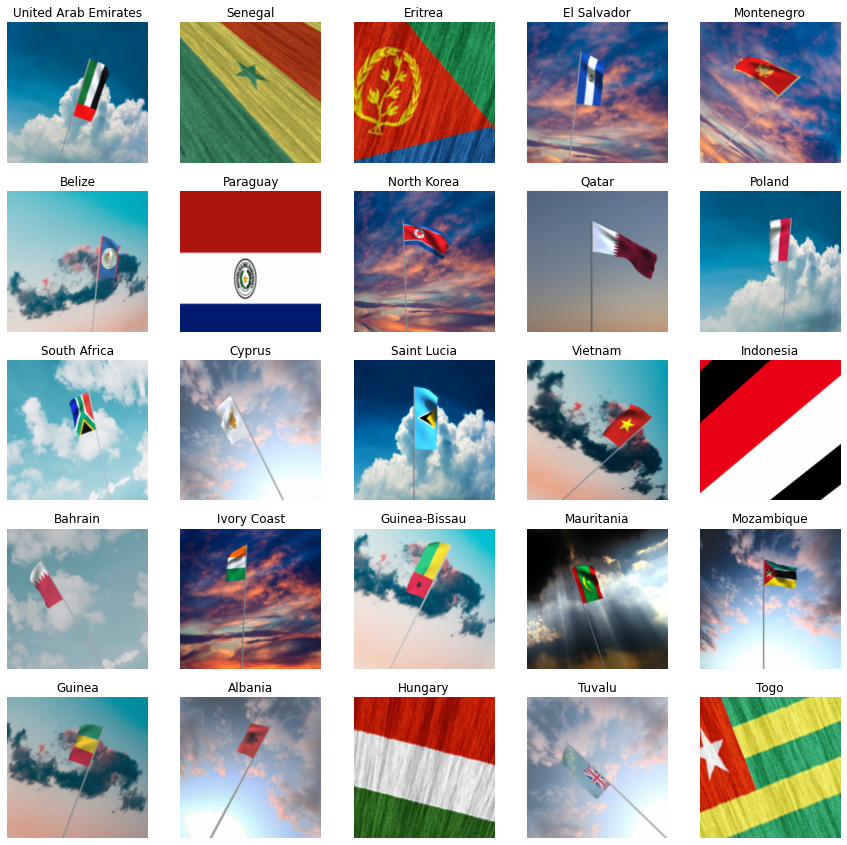

In [ ]:
# Muestro un conjunto de imágenes al azar
dls.train.show_batch(max_n=25)

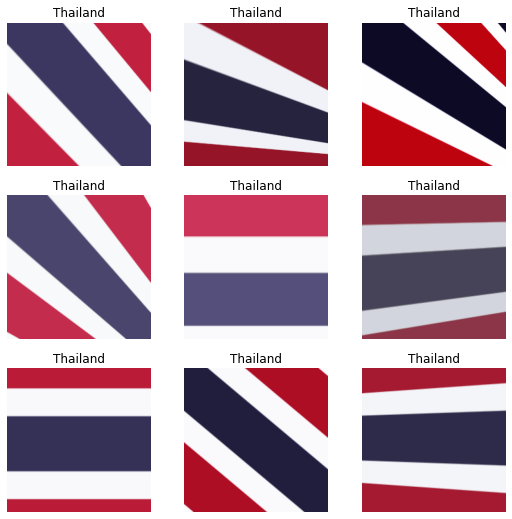

In [ ]:
# Muestro diferentes versiones de una misma imagen
dls.train.show_batch(max_n=9, unique=True)

# Modelo resnet34

In [ ]:
# Función que calcula la accuracy del top 3 
top_3_accuracy = partial(top_k_accuracy, k=3)

# Uso dos métricas
met = [accuracy,top_3_accuracy]

# Creo y preparo el modelo para ser entrenado
learn34 = cnn_learner(dls,              # Dataloaders
                    resnet34,           # Elijo la arquitectura resnet34
                    normalize=True,     # Normalizo los datos
                    pretrained=True,    # Uso transfer learning
                    n_out=num_classes,  # Cambio la cantidad ded neuronas de salida                    
                    opt_func=Adam,      # Optimizo con Adam                   
                    metrics=met,        # Elijo las métricas
                    wd=0.1).to_fp16()   # Aplico weigth decay para evitar overtting                    

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Entrenamiento (30 épocas)

SuggestedLRs(valley=0.0030199517495930195)

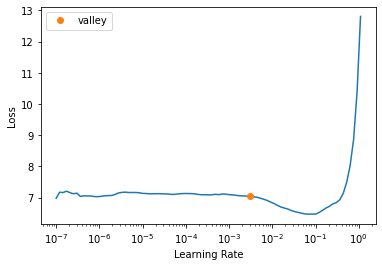

In [ ]:
# Busco cuál es el mejor learning rate
learn34.lr_find()

In [ ]:
learn34.fine_tune(30, 7e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.720207,5.464416,0.043779,0.089862,00:33


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.913847,4.671598,0.103687,0.207373,00:34
1,4.326832,3.864524,0.182028,0.345622,00:33
2,3.706656,2.944519,0.304147,0.493088,00:34
3,3.069106,2.285331,0.453917,0.658986,00:34
4,2.482482,1.793728,0.539171,0.771889,00:33
5,2.001236,1.520262,0.587558,0.797235,00:33
6,1.629397,1.336682,0.629032,0.827189,00:32
7,1.381530,1.266177,0.670507,0.841014,00:32
8,1.198777,1.316661,0.684332,0.845622,00:32
9,1.039958,1.234507,0.658986,0.861751,00:32


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f42cc99ccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


In [ ]:
# Guardo el modelo
learn34.save(folder/'models/resnet34_30epochs_flagpedia')

Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Proyecto final/models/resnet34_30epochs_flagpedia.pth')

## Resultados del entrenamiento

In [ ]:
# Cargo el modelo
learn34.load(folder/'models/resnet34_30epochs_flagpedia')

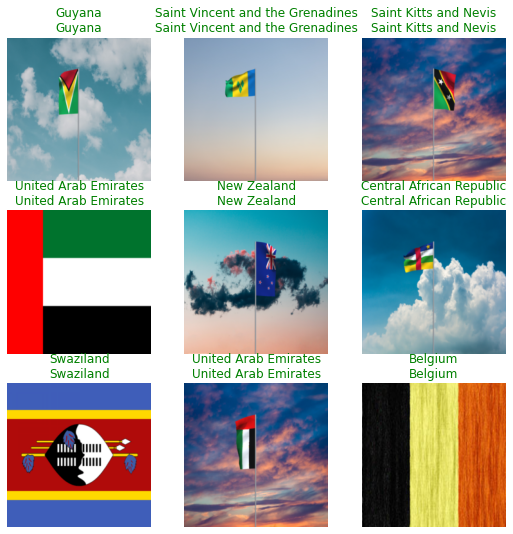

In [ ]:
# Muestro resultados al azar
learn34.show_results()

In [ ]:
# Creo un interpretador de resultados
interp34 = ClassificationInterpretation.from_learner(learn34)

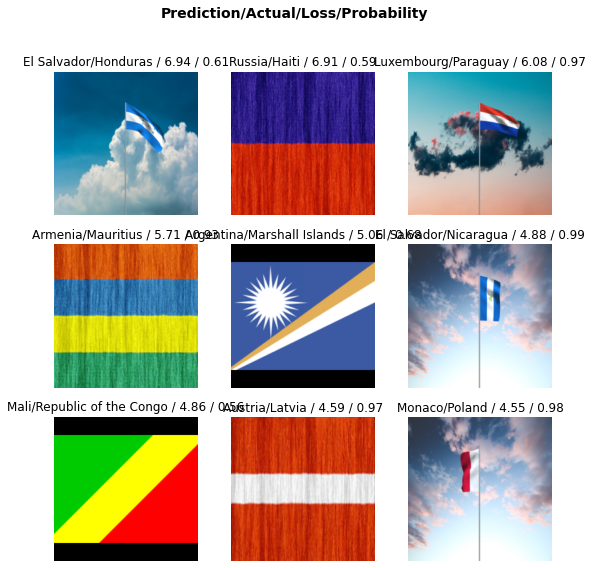

In [ ]:
# Plotteo las imágenes con mayor loss
interp34.plot_top_losses(range(0,9))

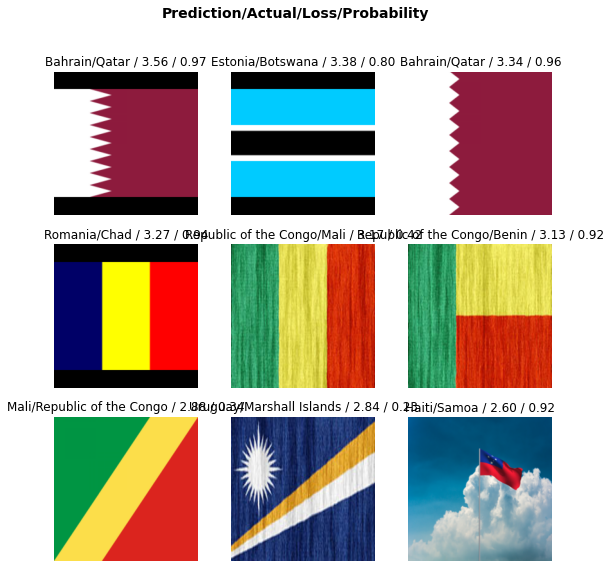

In [ ]:
# Plotteo las imágenes con mayor loss
interp34.plot_top_losses(range(9,18))

In [ ]:
# Miro cuáles son los errores que más se repiten
interp34.most_confused()

[('Chad', 'Romania', 4),
 ('Qatar', 'Bahrain', 2),
 ('Republic of the Congo', 'Mali', 2),
 ('Armenia', 'Mauritius', 1),
 ('Austria', 'Indonesia', 1),
 ('Benin', 'Cameroon', 1),
 ('Benin', 'Republic of the Congo', 1),
 ('Botswana', 'Estonia', 1),
 ('Burkina Faso', 'Senegal', 1),
 ('Haiti', 'Russia', 1),
 ('Honduras', 'El Salvador', 1),
 ('Hungary', 'Luxembourg', 1),
 ('Indonesia', 'Monaco', 1),
 ('Ireland', 'Ivory Coast', 1),
 ('Kingdom of the Netherlands', 'Latvia', 1),
 ('Latvia', 'Austria', 1),
 ('Lesotho', 'Finland', 1),
 ('Liechtenstein', 'Haiti', 1),
 ('Mali', 'Guinea', 1),
 ('Mali', 'Republic of the Congo', 1),
 ('Marshall Islands', 'Argentina', 1),
 ('Marshall Islands', 'Russia', 1),
 ('Marshall Islands', 'Uruguay', 1),
 ('Mauritius', 'Armenia', 1),
 ('Monaco', 'Indonesia', 1),
 ('Monaco', 'Poland', 1),
 ('New Zealand', 'Australia', 1),
 ('Nicaragua', 'El Salvador', 1),
 ('Paraguay', 'Luxembourg', 1),
 ('Poland', 'Monaco', 1),
 ('Romania', 'Chad', 1),
 ('Samoa', 'Haiti', 1),
 ('

# Modelo resnet50

In [ ]:
# Función que calcula la accuracy del top 3 
top_3_accuracy = partial(top_k_accuracy, k=3)

# Uso dos métricas
met = [accuracy,top_3_accuracy]

# Creo y preparo el modelo para ser entrenado
learn50 = cnn_learner(dls,              # Dataloaders
                    resnet50,           # Elijo la arquitectura resnet34
                    normalize=True,     # Normalizo los datos
                    pretrained=True,    # Uso transfer learning
                    n_out=num_classes,  # Cambio la cantidad ded neuronas de salida                    
                    opt_func=Adam,      # Optimizo con Adam                   
                    metrics=met,        # Elijo las métricas
                    wd=0.1).to_fp16()   # Aplico weigth decay para evitar overtting  

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Entrenamiento (40 épocas)

SuggestedLRs(valley=0.0012022644514217973)

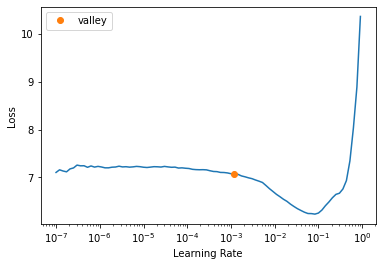

In [ ]:
# Busco cuál es el mejor learning rate
learn50.lr_find()

In [ ]:
lr = 5e-3
learn50.fine_tune(50, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.794857,5.526337,0.046083,0.105991,03:41


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.465409,4.184454,0.142857,0.262673,00:43
1,3.740252,3.311105,0.264977,0.440092,00:43
2,3.059849,2.505222,0.426267,0.608295,00:43
3,2.466991,1.879078,0.539171,0.709677,00:43
4,1.962767,1.479227,0.617512,0.799539,00:43
5,1.553168,1.257393,0.656682,0.873272,00:43
6,1.242016,1.182148,0.686636,0.859447,00:44
7,1.002664,0.942797,0.735023,0.889401,00:43
8,0.826398,0.971470,0.755760,0.907834,00:44
9,0.699704,0.925577,0.762673,0.912442,00:43


In [ ]:
learn50.save(folder/'models/resnet50_50epochs_flagpedia')

Path('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Proyecto final/models/resnet50_50epochs_flagpedia.pth')

## Resultados del entrenamiento

In [ ]:
# Cargo el modelo
learn50.load(folder/'models/resnet50_40epochs_flagpedia')

In [ ]:
learn50.export()

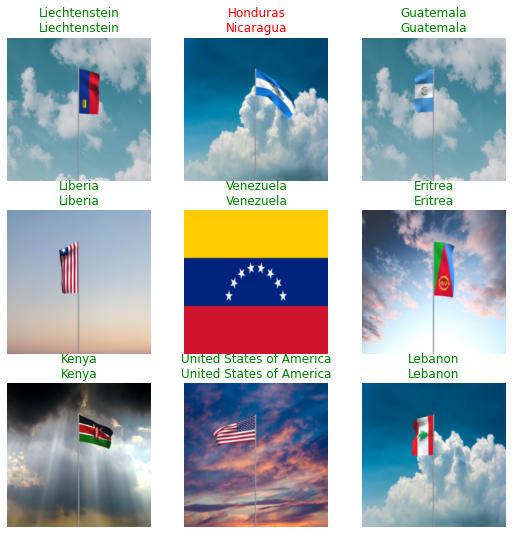

In [ ]:
# Muestro resultados al azar
learn50.show_results()

In [ ]:
# Creo un interpretador de resultados
interp50 = ClassificationInterpretation.from_learner(learn50)

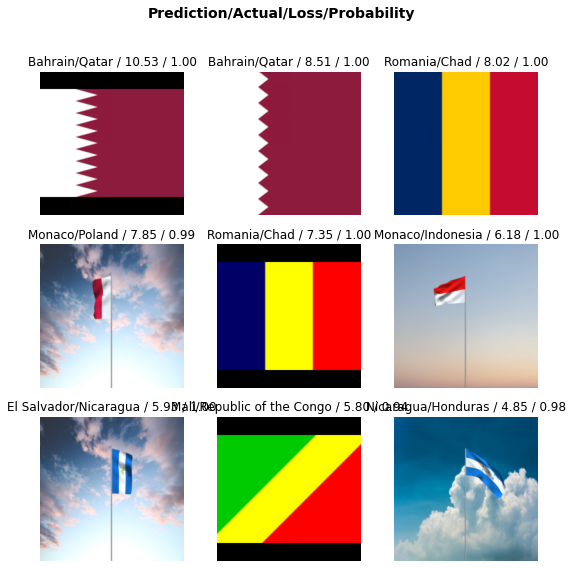

In [ ]:
# Plotteo las imágenes con mayor loss
interp50.plot_top_losses(range(0,9))

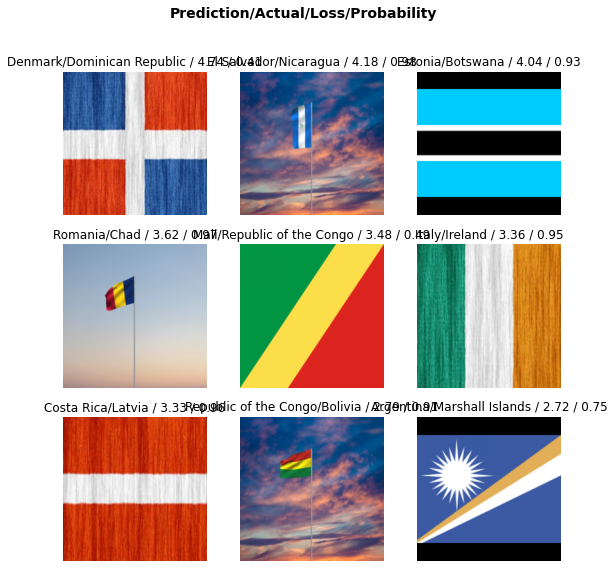

In [ ]:
# Plotteo las imágenes con mayor loss
interp50.plot_top_losses(range(9,18))

In [ ]:
# Miro cuáles son los errores que más se repiten
interp50.most_confused()

[('Chad', 'Romania', 4),
 ('Republic of the Congo', 'Mali', 3),
 ('Ireland', 'Ivory Coast', 2),
 ('Nicaragua', 'El Salvador', 2),
 ('Qatar', 'Bahrain', 2),
 ('Belgium', 'Romania', 1),
 ('Bolivia', 'Republic of the Congo', 1),
 ('Botswana', 'Estonia', 1),
 ('Dominican Republic', 'Denmark', 1),
 ('Greece', 'Israel', 1),
 ('Haiti', 'Russia', 1),
 ('Honduras', 'Nicaragua', 1),
 ('Indonesia', 'Monaco', 1),
 ('Ireland', 'Italy', 1),
 ('Kingdom of the Netherlands', 'Luxembourg', 1),
 ('Latvia', 'Costa Rica', 1),
 ('Lesotho', 'Nicaragua', 1),
 ('Mali', 'Guinea', 1),
 ('Marshall Islands', 'Argentina', 1),
 ('Moldova', 'Andorra', 1),
 ('Paraguay', 'Kingdom of the Netherlands', 1),
 ('Poland', 'Monaco', 1),
 ('Romania', 'Chad', 1),
 ('Turkmenistan', 'Portugal', 1)]

# Testeo y comparación de modelos

In [ ]:
def validate(learner, files, classes):
  acc = 0
  acc_top_3 = 0
  
  for f in files:
    pred_class, pred_idxs, outputs = learner.predict(f)
    top_3_conf, index = outputs.topk(3)

    if pred_class == label_func(f):
      acc += 1  

    for i in index:
      if classes[i.item()] == label_func(f):
        acc_top_3 += 1
        
  return (acc/len(files), acc_top_3/len(files))

In [21]:
files_test = get_image_files(folder/'test')

train_34 = learn34.validate()
train_50 = learn50.validate()
test_34 = validate(learn34, files_test, classes)
test_50 = validate(learn50, files_test, classes)

In [ ]:
print('Resultados de entrenamiento')
print('Modelo resnet34: Acc: ', train_34[1], 'Top3: ', train_34[2])
print('Modelo resnet50: Acc: ', train_50[1], 'Top3: ', train_50[2])

Resultados de entrenamiento
Modelo resnet34: Acc:  0.900921642780304 Top3:  0.9769585132598877
Modelo resnet50: Acc:  0.9262672662734985 Top3:  0.9907833933830261


In [ ]:
print('Resultados de testeo')
print('Modelo resnet34: Acc: ', test_34[0], 'Top3: ', test_34[1])
print('Modelo resnet50: Acc: ', test_50[0], 'Top3: ', test_50[1])

Resultados de testeo
Modelo resnet34: Acc:  0.5714285714285714 Top3:  0.7028571428571428
Modelo resnet50: Acc:  0.6857142857142857 Top3:  0.8114285714285714


In [ ]:
fla = folder/'test/pg/pg_2.jpg'
res = learn50.predict(fla)

pred_class, pred_idxs, outputs = learn50.predict(fla)
top_10_conf, i = outputs.topk(10)

itr = 0
classes = dls.vocab
for x in i:
    print(classes[x.item()], top_10_conf[itr].item()*100)
    itr=itr+1

Papua New Guinea 92.84453988075256
Singapore 3.5999733954668045
Japan 1.1108719743788242
Peru 0.26282654143869877
Australia 0.18492157105356455
Albania 0.1539053861051798
Montenegro 0.12463637394830585
Turkey 0.11800334323197603
South Korea 0.10014813160523772
Samoa 0.09518946753814816


# Producción

In [5]:
import anvil.media

def label_func(path):
  return

learn_inf = load_learner(folder/'export.pkl', cpu=True)

@anvil.server.callable
def predict_flag(file):
    
    with anvil.media.TempFile(file) as f:
      img = PILImage.create(f)

    results = 'Predictions: <br>'  
    pred,pred_idx,probs = learn_inf.predict(img)

    classes = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kingdom of the Netherlands', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', "People's Republic of China", 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Republic of the Congo', 'Romania', 'Russia', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Swaziland', 'Sweden', 'Switzerland', 'Syria', 'São Tomé and Príncipe', 'Tajikistan', 'Tanzania', 'Thailand', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']

    top_10_conf, i = probs.topk(10)
    itr = 0
    for x in i:
        results += f'{classes[x.item()]}: {top_10_conf[itr].item()*100:.04f}%'
        results += '<br>'
        itr=itr+1

    return results

anvil.server.wait_forever()    

KeyboardInterrupt: ignored